## Import relevant libraries

In [4]:
import pandas as pd
import numpy as np
import json
import torch
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
import seaborn as sns
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from PIL import Image
from torch.optim import lr_scheduler
from skimage import io
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights, SqueezeNet1_1_Weights, ResNet101_Weights
import torchvision.models as models
from PIL import ImageFile
import warnings
warnings.filterwarnings('ignore')

In [62]:
label_csv_path = '/notebooks/new_data/train.csv'
df = pd.read_csv(label_csv_path)
df.shape

(7704, 2)

In [11]:
df.head()

,image_name,pci
0,"10745_[40.72376740448161, -89.44599936927897]_...",100
1,"49812_[40.700766104509725, -89.3989279463273]_...",100
2,"60080_(40.69357, -89.45994)_ 2023-10-20 18-29-...",100
3,"2205_(40.7031665, -89.4067306666667)_ 2023-10-...",12
4,"28158_[40.7079780926376, -89.39486040573811]_ ...",100


## Plot PCI Distributions

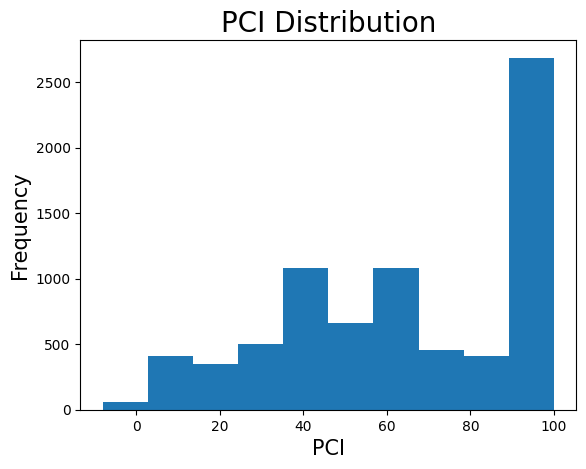

In [3]:
def plot_pci_dist(label_csv_path):
    labels = pd.read_csv(label_csv_path)
    labels['pci'].plot.hist();
    plt.title('PCI Distribution', size=20)
    plt.xlabel('PCI', size=15)
    plt.ylabel('Frequency', size=15)
    
plot_pci_dist(label_csv_path)

In [63]:
image_folder_path = 'data/train'

label = pd.read_csv('data/train.csv')
label.head(10)

,image_name,Section,PCI
0,"2_[40.71559672113631, -89.44453775765967]_ 202...",WEST CRUGER ROAD_1090.0,100
1,"6_(40.7157681666667, -89.4445288333333)_ 2023-...",WEST CRUGER ROAD_1090.0,4
2,"8_[40.71583783238075, -89.44448434498877]_ 202...",WEST CRUGER ROAD_1090.0,28
3,"11_(40.7159545, -89.4444771666667)_ 2023-10-18...",WEST CRUGER ROAD_1090.0,45
4,"18_[40.71609699834105, -89.44429173064164]_ 20...",WEST CRUGER ROAD_1090.0,82
5,"19_(40.7161271666667, -89.4442431666667)_ 2023...",WEST CRUGER ROAD_1090.0,88
6,"29_[40.716163677112554, -89.44372516272288]_ 2...",WEST CRUGER ROAD_1090.0,78
7,"46_(40.7163928333333, -89.4427958333333)_ 2023...",WEST CRUGER ROAD_1090.0,78
8,"61_[40.71653013205482, -89.44207694856078]_ 20...",WEST CRUGER ROAD_1090.0,82
9,"67_(40.7166245, -89.4417893333333)_ 2023-10-18...",WEST CRUGER ROAD_1090.0,82


## Create Dataset

In [2]:
# Loading images
class PCIDataset(Dataset):
    def __init__(self, label_csv, image_dir, transform=None, under_transform=None):
        self.labels = pd.read_csv(label_csv)
        
        files_to_remove = ['1119_(40.7034233333333, -89.4052588333333)_ 2023-10-18 15-49-01_14.30605_D.jpg', 
                   '11980_(40.6916493333333, -89.4393206666667)_ 2023-10-20 16-10-54_28.5085_D.jpg']

        self.labels = self.labels[~self.labels['image_name'].isin(files_to_remove)]
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.labels.iloc[idx, 1]
        label = torch.tensor(float(label)) if label >= 0 else torch.tensor(0.0)

        # if self.under_transform and label <= 60: # if the PCI is less than or equal 60, consider as underepresented 
        #     image = self.under_transform(image)
        # else:
        image = self.transform(image)

        return image, label

Deleted images: <br>
> Images were corrupted 

`new_data/train/1119_(40.7034233333333, -89.4052588333333)_ 2023-10-18 15-49-01_14.30605_D.jpg`
`new_data/train/11980_(40.6916493333333, -89.4393206666667)_ 2023-10-20 16-10-54_28.5085_D.jpg`

## Define Data Transforms 

In [64]:
# random.seed(0)

# Training transforns
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                           saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.RandomRotation(degrees=45),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

## Instantiate the Dataset

In [65]:
label_file_path =  'new_data/train.csv'
image_dir = 'new_data/train'
dataset = PCIDataset(label_csv=label_file_path, 
                            image_dir=image_dir, 
                            transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Perform Random data split
train_dataset, val_dataset = random_split(dataset, 
                                          [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=64, 
                          num_workers=8, pin_memory=True, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=8, 
                          pin_memory=True, shuffle=False) 

### Load ResNet Pretrained model 

> We train two variants of Resnet models: <br>


```python
ResNet50
ResNet101
```

```python
We adapt the head of the model and treat the 
task as a regression problem
```

```python
To train a resnet variant of some fixed number of layers:
e.g, number_of_layers = 101
models.resnet101(weights=True)
```


In [66]:
resnet_model = models.resnet101(weights=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Loss Function and Optimizer 

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [7]:
def train_and_validate(model, train_loader, valid_loader,
                       criterion, optimizer, scheduler, epochs, device):

    patience = 500
    counter_early_stop = 0
    early_stop = False
    best_val_loss = 1000000

    model.train()
    train_losses, val_losses, val_mapes = [], [], []

    for epoch in tqdm(range(epochs)):
        total_train_loss = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Learning rate scheduler step
        # scheduler.step()

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_mape = 0

        with torch.no_grad():
            for data, targets in valid_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets.float())
                total_val_loss += val_loss.item()

                #Calculate MAPE
                nonzero_indices = targets != 0
                outputs = outputs[nonzero_indices]
                targets = targets[nonzero_indices]

                mape = torch.mean(torch.abs((targets - outputs.squeeze()) / targets)) * 100
                total_val_mape += mape.item()

        val_loss = total_val_loss / len(valid_loader)
        val_losses.append(val_loss)
        val_mape = total_val_mape / len(valid_loader)
        val_mapes.append(val_mape)
        
        # Apply learning rate scheduler after Validation
        # plateau_scheduler.step(val_loss)
        # Save thes last checkpoint 
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'train loss' : train_loss,
        #     'val loss':val_loss,
        #     'val mape':val_mape,
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'scheduler_state_dict': scheduler.state_dict(),
        # }, 'trained_models/new_dataset/last_model_resnet101_full_dataset_random_split.pth')

        # Save the model if validation loss has improved
        
        if val_loss < best_val_loss:

            best_val_loss = val_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train loss' : train_loss,
            'val loss' : val_loss,
            'val mape': val_mape,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            }, 'trained_models/new_dataset/best_resnet101_full_dataset_random_split_deadline.pth')
            print("Model saved as validation loss improved.")
            counter_early_stop = 0

        else:
            counter_early_stop += 1
            if counter_early_stop >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}.")
                early_stop = True
                break

        if early_stop:
            print("Early stopping")
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAPE: {val_mape:.2f}%')

    return train_losses, val_losses, val_mapes

## Load trained Model from checkpoint

In [51]:
# Load the checkpoint
PATH_TO_MODEL_CHECKPOINT = '/notebooks/best_model_results/best_model_resnet50_full_dataset_random_split_v3.pth'
model = models.resnet50(weights=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(PATH_TO_MODEL_CHECKPOINT)

model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# The epoch number can be used to resume training
last_epoch = checkpoint['epoch']
print('Last epoch :', last_epoch)
print('Val loss :', checkpoint['val loss'])
print('Val MAPE :', checkpoint['val mape'])

model = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Last epoch : 172
Val loss : 239.14605947641226
Val MAPE : 44.229422055757965


## Train the model 

To train the `ResNet` model:

Run the cell below:

In [8]:
epochs = 500
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


train_losses, val_losses, val_mapes = train_and_validate(
    model=resnet_model, # change name if loading from a checkpoint
    optimizer=optimizer,
    scheduler=step_lr_scheduler, 
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    epochs=epochs,
    device=device
)

  0%|          | 0/500 [00:00<?, ?it/s]

Model saved as validation loss improved.
Epoch 1/500, Train Loss: 2660.3424, Val Loss: 1450.3781, Val MAPE: 60.31%
Model saved as validation loss improved.
Epoch 2/500, Train Loss: 615.9401, Val Loss: 435.3592, Val MAPE: 60.83%
Model saved as validation loss improved.
Epoch 3/500, Train Loss: 416.1014, Val Loss: 359.9124, Val MAPE: 64.04%
Epoch 4/500, Train Loss: 378.9827, Val Loss: 440.5220, Val MAPE: 48.96%
Model saved as validation loss improved.
Epoch 5/500, Train Loss: 376.3316, Val Loss: 350.3273, Val MAPE: 58.87%
Model saved as validation loss improved.
Epoch 6/500, Train Loss: 340.8847, Val Loss: 321.4392, Val MAPE: 59.72%
Epoch 7/500, Train Loss: 334.3678, Val Loss: 329.6518, Val MAPE: 56.04%
Epoch 8/500, Train Loss: 311.7746, Val Loss: 338.4891, Val MAPE: 48.90%
Epoch 9/500, Train Loss: 319.4106, Val Loss: 325.5968, Val MAPE: 48.05%
Model saved as validation loss improved.
Epoch 10/500, Train Loss: 295.0122, Val Loss: 305.2535, Val MAPE: 57.01%
Model saved as validation loss 

KeyboardInterrupt: 

## Create Test Dataset for Inference

In [52]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

class PCITestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(img_dir) if 
                          img.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except IOError as e:
            print(f"Error loading image {img_path}: {e}. Skipping.")
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, img_name  

## Define Test Data Transforms

In [53]:
# Defining the transform for the test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


# Test time data augmentation
test_augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=45),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


# Create the test dataset
test_dataset = PCITestDataset(img_dir='new_data/test', transform=test_transform)

# Create the DataLoader for the test set
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## Predicting PCI using Test Dataset

In [6]:
def return_model_results(model, test_loader, device):
    '''
    model: - model checkpoint for inference
    test_laoder - dataloader for test data
    '''
    model.eval()
    predictions = []

    with torch.no_grad():
        for data, file_names in tqdm(test_loader):
            data = data.to(device)
            outputs = model(data).squeeze()

            outputs = outputs.cpu().numpy()

            outputs = np.round(outputs)  
            outputs = np.clip(outputs, 0, 100) 

            for file_name, output in zip(file_names, outputs):
                predictions.append({'image_name': file_name, 'PCI': output})

    return pd.DataFrame(predictions)

In [55]:
results = return_model_results(model, test_loader, device)
results.head() 

  0%|          | 0/52 [00:00<?, ?it/s]

,image_name,PCI
0,"29346_(40.706639, -89.4118548333333)_ 2023-10-...",100.0
1,"30469_[40.71754494378192, -89.40737241483934]_...",52.0
2,"5391_[40.703573729608635, -89.39307207576425]_...",100.0
3,"8177_[40.70344959878703, -89.40285044078563]_ ...",38.0
4,"50640_[40.71631585548975, -89.44329904297382]_...",38.0


## Generate JSON file for submission

In [ ]:
JSON_SUBMISSION_NAME = 'resnet50_v3.json'

`JSON` file for submission will be saved at the current directory

In [57]:
def gen_submit(df):
    out_json = []
    for idx, results in df.iterrows():
        out_json.append({results['image_name']: results['PCI']})
    with open(JSON_SUBMISSION_NAME, 'w') as f:
        json.dump(out_json, f)

gen_submit(results)